# ML in Cybersecurity: Project II

## Team
  * **Team name**: *Good Fellows*
  * **Members**:  *fill this in. format: Md. Abdul Kadir (s8mdkadi@stud.uni-saarland.de), Hasan Md Tusfiqur Alam (s8haalam@stud.uni-saarland.de), ...*


## Logistics
  * **Due date**: 28th November 2019, 13:59:59 (right before the lecture)
  * Email the completed notebook to: `mlcysec_ws1920_staff@lists.cispa.saarland`
  * Complete this in **teams of 3**
  * Feel free to use the course [mailing list](https://lists.cispa.saarland/listinfo/mlcysec_ws1920_stud) to discuss.
  
## Timeline
  * 14-Nov-2019: Project 2 hand-out
  * **28-Nov-2019** (13:59:59): Email completed notebook
  * 5-Nov-2019: Project 2 discussion and summary
  
  
## About this Project
In this project, you will explore an application of ML to a popular task in cybersecurity: malware classification.
You will be presented with precomputed behaviour analysis reports of thousands of program binaries, many of which are malwares.
Your goal will be train a malware detector using this behavioural reports.


## A Note on Grading
The grading for this project will depend on:
 1. Vectorizing Inputs
   * Obtaining a reasonable vectorized representations of the input data (a file containing a sequence of system calls)
   * Understanding the influence these representations have on your model
 1. Classification Model  
   * Following a clear ML pipeline
   * Obtaining reasonable performances (>60\%) on held-out test set
   * Choice of evaluation metric
   * Visualizing loss/accuracy curves
 1. Analysis
   * Which methods (input representations/ML models) work better than the rest and why?
   * Which hyper-parameters and design-choices were important in each of your methods?
   * Quantifying influence of these hyper-parameters on loss and/or validation accuracies
   * Trade-offs between methods, hyper-parameters, design-choices
   * Anything else you find interesting (this part is open-ended)


## Grading Details
 * 40 points: Vectorizing input data (each input = behaviour analysis file in our case)
 * 40 points: Training a classification model
 * 15 points: Analysis/Discussion
 * 5 points: Clean code
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.


**The notebook is your project report. So, to make the report readable, omit code for techniques/models/things that did not work. You can use final summary to provide report about these codes.**

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.1: Updated deadline
  * v1.0: Initial notebook
  
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 
import pathlib
from pathlib import Path
import itertools  
import collections 
from IPython.display import display, HTML
from livelossplot import PlotLosses
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2



In [2]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.


# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [3]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '2'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

# Setup

  * Download the datasets: [train](https://nextcloud.mpi-klsb.mpg.de/index.php/s/pJrRGzm2So2PMZm) (128M) and [test](https://nextcloud.mpi-klsb.mpg.de/index.php/s/zN3yeWzQB3i5WqE) (92M)
  * Unpack them under `./data/train` and `./data/test`

In [4]:
# Check that you are prepared with the data
! printf '# train examples (Should be 13682) : '; ls data/train | wc -l
! printf '# test  examples (Should be 10000) : '; ls data/test | wc -l

# train examples (Should be 13682) :    13682
# test  examples (Should be 10000) :    10000


Now that you're set, let's briefly look at the data you have been handed.
Each file encodes the behavior report of a program (potentially a malware), using an encoding scheme called "The Malware Instruction Set" (MIST for short).
At this point, we highly recommend you briefly read-up Sec. 2 of the [MIST](http://www.mlsec.org/malheur/docs/mist-tr.pdf) documentation.

You will find each file named as `filename.<malwarename>`:
```
» ls data/train | head
00005ecc06ae3e489042e979717bb1455f17ac9d.NothingFound
0008e3d188483aeae0de62d8d3a1479bd63ed8c9.Basun
000d2eea77ee037b7ef99586eb2f1433991baca9.Patched
000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
0010f78d3ffee61101068a0722e09a98959a5f2c.Basun
0013cd0a8febd88bfc4333e20486bd1a9816fcbf.Basun
0014aca72eb88a7f20fce5a4e000c1f7fff4958a.Texel
001ffc75f24a0ae63a7033a01b8152ba371f6154.Texel
0022d6ba67d556b931e3ab26abcd7490393703c4.Basun
0028c307a125cf0fdc97d7a1ffce118c6e560a70.Swizzor
...
```
and within each file, you will see a sequence of individual systems calls monitored duing the run-time of the binary - a malware named 'Basun' in the case:
```
» head data/train/000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
# process 000006c8 0000066a 022c82f4 00000000 thread 0001 #
02 01 | 000006c8 0000066a 00015000
02 02 | 00006b2c 047c8042 000b9000
02 02 | 00006b2c 047c8042 00108000
02 02 | 00006b2c 047c8042 00153000
02 02 | 00006b2c 047c8042 00091000
02 02 | 00006b2c 047c8042 00049000
02 02 | 00006b2c 047c8042 000aa000
02 02 | 00006b2c 047c8042 00092000
02 02 | 00006b2c 047c8042 00011000
...
```
(**Note**: Please ignore the first line that begins with `# process ...`.)

Your task in this project is to train a malware detector, which given the sequence of system calls (in the MIST-formatted file like above), predicts one of 10 classes: `{ Agent, Allaple, AutoIt, Basun, NothingFound, Patched, Swizzor, Texel, VB, Virut }`, where `NothingFound` roughly represents no malware is present.
In terms of machine learning terminology, your malware detector $F: X \rightarrow Y$ should learn a mapping from the MIST-encoded behaviour report (the input $x \in X$) to the malware class $y \in Y$.

Consequently, you will primarily tackle two challenges in this project:
  1. "Vectorizing" the input data i.e., representing each input (file) as a tensor
  1. Training an ML model
  

### Some tips:
  * Begin with an extremely simple representation/ML model and get above chance-level classification performance
  * Choose your evaluation metric wisely
  * Save intermediate computations (e.g., a token to index mapping). This will avoid you parsing the entire dataset for every experiment
  * Try using `multiprocessing.Pool` to parallelize your `for` loops

---

# 1. Vectorize Data

## 1.a. Load Raw Data

In [5]:
def file_load_kernel(filepath):
    '''Given a filepath, returns (content, classname), where content = [list of lines in file]'''
    #
    #
    # ------- Your Code -------
    #
    #
    
    # Parse the file name and identify the class name.
    label = filepath.split('.')[2]
    
    # Read the file 
    with open(filepath, 'r') as file :
        lines = file.read().splitlines()
    if '# process' in lines[0] :
        del lines[0]
    
    
    # Remove the firstline start with "# process"
    
    # Convert text file to list , content of list is the lines of the textfile.
    
    
    
    return lines, label

def file_load_kernel_token(filepath):
    '''Given a filepath, returns (content, classname), where content = [list of lines in file]'''
    #
    #
    # ------- Your Code -------
    #
    #
    
    # Parse the file name and identify the class name.
    label = filepath.split('.')[2]
    
    # Read the file 
    with open(filepath, 'r') as file :
        lines = file.read().splitlines()
    if '# process' in lines[0] :
        del lines[0]
    
    
    # Remove the firstline start with "# process"
    
    # Convert text file to list , content of list is the lines of the textfile.
    
    
    
    return lines

def handler(function, data, workers=6):
    
    with Pool(workers) as pool:
        #pool.map(cycle, offsets)
        r = pool.map(function, data)
    return r

def load_data(data_path, nworkers=6):
    '''Returns each data sample as a tuple (x, y), x = sequence of strings (i.e., syscalls), y = malware program class'''
    raw_data_samples = []
    #
    #
    # ------- Your Code -------
    #
    #
    files = os.listdir(data_path)
    raw_data_samples = []
    
    #file_chunks = [tokens[x:x+1000] for x in range(0, len(tokens), 1000)]
    
    # Removing the empty index
    file_addresses = []
    del files[-1]
    i = 1
    print('Total file is: ', len(files) )
    for file in files:
        file_addresses.append (os.path.join(data_path,file))
        print('Reading file: ', i)
        i += 1
        if i> 500:
            break #comment this to load whole dataset

    #print(file_addresses)
    raw_data_samples = handler(file_load_kernel,file_addresses,workers=4)
    return raw_data_samples

In [6]:
# Test 

#print(file_load_kernel('./data/train/fffb9be0177ac57f213bc089b319582936a5bd08.NothingFound'))
#print(load_data('./data/train', nworkers=4)[0])

## 1.b. Vectorize: Setup

Make one pass over the inputs to identify relevant features/tokens.

Suggestion:
  - identify tokens (e.g., unigrams, bigrams)
  - create a token -> index (int) mapping. Note that you might have a >10K unique tokens. So, you will have to choose a suitable "vocabulary" size.

In [7]:
# Feel free to edit anything in this block
def countFrequency(my_list): 
      # This taking long time to read
    # Creating an empty dictionary  
    i = 1
    freq = {} 
    for items in my_list: 
        print('Counting frequency in ', i , ' file')
        freq[items] = my_list.count(items) 
        i = 1 +1
    return freq 



# it use multiple files to create a frequency counter
def load_multiple_files_frequecy_list(file_list):
    raw_data_samples = handler(file_load_kernel_token,file_list, workers=6)
    print('raw data collection fininshed')
    print('raw data length in each chunk', len(raw_data_samples))
    list_of_dict = handler(countFrequency, raw_data_samples, workers=6) # This line taking longer time 
    print('multiprocess finished')
    return  {k: v for d in list_of_dict for k, v in d.items()}
    

def get_key_idx_map(counter, vocab_size, ukn_token='_ukn_'):
    # counter is a mapping: token -> count
    # build vectorizer using vocab_size most common elements
    counter_unk = counter
    idx_to_key = {}
    key_to_idx = {}
    
    
    if len(counter)< vocab_size:
        counter_unk.update({ukn_token:(vocab_size - len(counter))})
        
    counter_unk = dict(sorted(counter_unk.items(), key=lambda x: x[1], reverse=True))
    
    for i in range(len(counter_unk)):
        idx_to_key.update({i:list(counter_unk.keys())[i]})
        key_to_idx.update({list(counter_unk.keys())[i]:i})
    
    #key_to_idx, idx_to_key = dict(), dict()
    return key_to_idx, idx_to_key
# Helper class to get all text files in a list
def get_all_file_address(directory):
    files = os.listdir(directory)
    files = [os.path.join(directory,file) for file in files]
    
    return files
# helper class to get token count

    

def get_class_key_index_map(class_counter):
  #  { 'Agent':0, 'Allaple':1, 'AutoIt': 2, 'Basun':3, 'NothingFound':4, 'Patched': 5, 'Swizzor':6, 'Texel':7, 'VB': 8, 'Virut':9 }
    class_index = class_counter
    index_class = dict((v,k) for k,v in class_index.items())
    nb_classes = len(class_counter)
    targets = np.array([class_counter.keys()]).reshape(-1)
    one_hot_targets = np.eye(nb_classes).tolist()
    class_index = dict(zip([*class_index], one_hot_targets))
    return class_index, index_class



In [8]:
# Test
#my_map = {'a': 1, 'b': 2}
#print(get_key_idx_map(my_map,4))
classes = { 'Agent':0, 'Allaple':1, 'AutoIt': 2, 'Basun':3, 'NothingFound':4, 'Patched': 5, 'Swizzor':6, 'Texel':7, 'VB': 8, 'Virut':9 }
class_onehot, index_class = get_class_key_index_map(classes)
#print(class_onehot)
#print(index_class)


In [9]:
'''# List of all files 

training_files = get_all_file_address('./data/train')
print(len(training_files))
multiple_training_file_chunk = [training_files[x:x+200] for x in range(0, len(training_files),200)]
print(len(multiple_training_file_chunk))

print("length of each chunk will oprocessed in pool", len(multiple_training_file_chunk[0]))
# Reading token count using multiprocessing handaller 
#list_dict_count = handler(load_multiple_files_frequecy_list, multiple_training_file_chunk, workers=4)

print(len(load_multiple_files_frequecy_list(multiple_training_file_chunk[0])))

count_dict = {}

#for l in multiple_training_file_chunk:
#    count_dict = {**count_dict, **load_multiple_files_frequecy_list(l)}
#    print('counting the key')
    

#print(len(count_dict))
'''

'# List of all files \n\ntraining_files = get_all_file_address(\'./data/train\')\nprint(len(training_files))\nmultiple_training_file_chunk = [training_files[x:x+200] for x in range(0, len(training_files),200)]\nprint(len(multiple_training_file_chunk))\n\nprint("length of each chunk will oprocessed in pool", len(multiple_training_file_chunk[0]))\n# Reading token count using multiprocessing handaller \n#list_dict_count = handler(load_multiple_files_frequecy_list, multiple_training_file_chunk, workers=4)\n\nprint(len(load_multiple_files_frequecy_list(multiple_training_file_chunk[0])))\n\ncount_dict = {}\n\n#for l in multiple_training_file_chunk:\n#    count_dict = {**count_dict, **load_multiple_files_frequecy_list(l)}\n#    print(\'counting the key\')\n    \n\n#print(len(count_dict))\n'

In [ ]:
# Feel free to edit anything in this block
# Count maximum vocab size

# Comment this after a full run. 
training_data = load_data('./data/train', nworkers=6)
    
print('training data reading finish')
tokens = []
for pairs in training_data:
    tokens = tokens + pairs[0]

token_chunks = [tokens[x:x+1000] for x in range(0, len(tokens), 1000)]

print('token generation is done')
#print(tokens)
MAX_VOCAB_SIZE = len(set(tokens)) + 100 # Assumtion 

token_counter =  handler(countFrequency,token_chunks)

combined_token_dict = {k: v for d in token_counter for k, v in d.items()}

#print(token_counter)
print('frequency counting is done')
print()
token_to_idx, idx_to_token = get_key_idx_map(combined_token_dict, MAX_VOCAB_SIZE)    
# Save vocab to file

out_path = 'application_vocab_{}.pkl'.format(MAX_VOCAB_SIZE)
with open(out_path, 'wb') as wf:
    dct = {'token_to_idx': token_to_idx,
          'idx_to_token': idx_to_token}
    pickle.dump(dct, wf)
    

    

Total file is:  13681
Reading file:  1
Reading file:  2
Reading file:  3
Reading file:  4
Reading file:  5
Reading file:  6
Reading file:  7
Reading file:  8
Reading file:  9
Reading file:  10
Reading file:  11
Reading file:  12
Reading file:  13
Reading file:  14
Reading file:  15
Reading file:  16
Reading file:  17
Reading file:  18
Reading file:  19
Reading file:  20
Reading file:  21
Reading file:  22
Reading file:  23
Reading file:  24
Reading file:  25
Reading file:  26
Reading file:  27
Reading file:  28
Reading file:  29
Reading file:  30
Reading file:  31
Reading file:  32
Reading file:  33
Reading file:  34
Reading file:  35
Reading file:  36
Reading file:  37
Reading file:  38
Reading file:  39
Reading file:  40
Reading file:  41
Reading file:  42
Reading file:  43
Reading file:  44
Reading file:  45
Reading file:  46
Reading file:  47
Reading file:  48
Reading file:  49
Reading file:  50
Reading file:  51
Reading file:  52
Reading file:  53
Reading file:  54
Reading file:  

training data reading finish
token generation is done
Counting frequency in  1  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequen

Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting

Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting

Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting

Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  1  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting

Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting

Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting

Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting frequency in  2  file
Counting

In [ ]:
#print(token_to_idx)
#print(idx_to_token)

## 1.c. Vectorize Data

Use the (token $\rightarrow$ index) mapping you created before to vectorize your data

In [61]:
#
#
# ------- Your Code -------
#
#
# Load the data from pickle file 

vectorized_file = open(out_path,'rb')  # CHNAGE THE NAME OF FILE
vectorizer_data = pickle.load(vectorized_file)
vectorized_file.close()
print(type(vectorizer_data))

<class 'dict'>


In [75]:
def vectorize_raw_samples(raw_samples, nworkers=4):
    vectorized_samples = []
    
    #
    #
    # ------- Your Code -------
    #
    #
    token_to_idx = vectorizer_data['token_to_idx']
    data = load_data(raw_samples, nworkers)
    
    #tokens_list = list(token_to_idx.keys())
    #print(tokens_list)
    
    
    
    for l in data:
        temp_list = [0 for i in range(len(token_to_idx))]
        
        
        
        
        for i in l[0]:
            # The method is called bag of words
            index = token_to_idx.get(i)#[token_to_idx[i]]
            if index:
                temp_list[index] = 1
                #temp_list.append(index)
            else:
                temp_list[token_to_idx.get('_ukn_')] = 0
                #temp_list.append(token_to_idx.get('_ukn_'))
        if(class_onehot.get(l[1])):
            vectorized_samples.append((temp_list, class_onehot.get(l[1])))
        else:
            vectorized_samples.append((temp_list, class_onehot.get( 'NothingFound'))) 
        #vectorized_samples.append(([token_to_idx.get(i) if token_to_idx.get(i) else token_to_idx.get('_ukn_') for  i in l[0]], l[1]))
    
    
    return vectorized_samples

In [76]:
def store_as_pickle(file_name, data):
    with open(file_name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def load_from_pickle(file_name):
    with open(file_name, "rb") as input_file:
        data = pickle.load(input_file)
        return data

In [79]:
print('=> Processing: Train')
train_raw_samples = './data/train'
test_raw_samples = './data/test'
train_data = vectorize_raw_samples(train_raw_samples) # comment this line after first run
print('=> Processing: Test')
test_data = vectorize_raw_samples(test_raw_samples) # Comment this line after first run
#train_data = load_from_pickle('training_data.pickle')
#test_data = load_from_pickle('test_data.pickle')
#print(train_data)
#print(test_data[0])

store_as_pickle('training_data.pickle', train_data)
store_as_pickle('test_data.pickle', test_data)

=> Processing: Train
=> Processing: Test


In [80]:
#
#
# ------- Your Code -------
#
#
def max_list_lenght(list_2d):
    max_len = 0
    for i in list_2d:
        if len(i)> max_len:
            max_len = len(i)
    return max_len
        

train_x , train_y = [x for x,_ in train_data],[y for _,y in train_data]
test_x , test_y = [x for x,_ in test_data],[y for _,y in test_data]

max_len = max_list_lenght(train_x)
train_x = [x + [0] * (max_len - len(x)) for x in train_x]
#print(train_x)
train_x = torch.tensor(train_x)


train_y = torch.FloatTensor(train_y)
test_x = [x + [0] * (max_len - len(x)) for x in test_x]
test_x = torch.FloatTensor(test_x)
test_y = torch.FloatTensor(test_y)



#print(train_y)

# Suggestions: 
#
# (a) You can use torch.utils.data.TensorDataset to represent the tensors you created previously
trainset = TensorDataset(train_x, train_y)  
testset = TensorDataset(test_x, test_y)
#
# (b) Store your datasets to disk so that you do not need to precompute it every time



# 2. Train Model

You will now train an ML model on the vectorized datasets you created previously.

_Note_: Although I often refer to each input as a 'vector' for simplicity, each of your inputs can also be higher dimensional tensors.

## 2.a. Helpers

In [81]:
# Feel free to edit anything in this block

def evaluate_preds(y_gt, y_pred):
    y_gt = [np.where(r==1)[0][0] for r in y_gt]
    y_pred = [np.where(r==1)[0][0] for r in y_pred]

    return 0


def another_helper(question):
    return 42


def save_model(model, out_path):
    torch.save(model.state_dict(), out_path)


def save_data(eval_data, out_path):
    with open(out_path, 'wb') as handle:
        pickle.dump(eval_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

## 2.b. Define Model

Describe your model here.

In [82]:
# Feel free to edit anything in this block

class NetDNN(nn.Module):
    def __init__(self, in_dims, h1, h2, out_dims):
        super(NetDNN, self).__init__()
        # Layer definitions
        self.fc1 = nn.Linear(in_dims, h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,out_dims)

    def forward(self, x):
        # Forward pass
        x =  F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x =  F.softmax(self.fc3(x))
        return x

## 2.c. Set Hyperparameters

In [83]:
# Define your hyperparameters here

in_dims = trainset[0][0].shape[0]
print('Input di',in_dims)
h1, h2 = 128, 128
out_dims = len(index_class)
print('Output dim', out_dims)

# Optimization
n_epochs = 25
batch_size = 32 # Originally 32
lr = 1e-2
momentum = 0.9

Input di 16240
Output dim 10


## 2.d. Train your Model

In [84]:
# Feel free to edit anything in this block

net = NetDNN(in_dims, h1, h2, out_dims)
net.train()

criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

# Data Loaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

dataloader = {'train': trainloader,'val': testloader}

# Etc.

In [85]:
#
#
# ------- Your Code -------
#
# Example:
from livelossplot import PlotLosses

def train_model(model,criterion, optimizer, n_epochs):
    eval_data = {}
    model = model.to(device)
    live_plot = PlotLosses()
    epoch_list = []
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    for epoch in range(n_epochs):
        logs = {}
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            if phase == 'val':
                model.eval()

            running_loss = 0.0
            ruuning_corrects = 0


            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs.float())
                labels = labels.to(device=device, dtype=torch.int64)
                loss = criterion(outputs, torch.max(labels, 1)[1])

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()


            _, preds = torch.max(outputs, 1)

            running_loss += loss.detach()* inputs.size(0)
            labels_nonhot =  torch.tensor([np.where(r==1)[0][0] for r in labels.data])

            ruuning_corrects += torch.sum(preds == labels_nonhot)

            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = ruuning_corrects.float() / len(dataloader[phase].dataset)
      
            prefix = ''
            if phase == 'val':
                prefix = 'val_'

            logs[prefix + 'log_loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
            
        epoch_list.append(epoch)
        train_loss_list.append(logs['log_loss'])
        test_loss_list.append(logs['val_log_loss'])
        train_acc_list.append(logs['accuracy'])
        test_acc_list.append(logs['val_accuracy'])
        live_plot.update(logs)
        live_plot.draw()
    eval_data['epoch'] = epoch_list
    eval_data['train_loss'] = train_loss_list
    eval_data['test_loss'] = test_loss_list
    eval_data['train_acc'] = train_acc_list
    eval_data['test_acc'] = test_acc_list
    
    return model, eval_data   
    


    


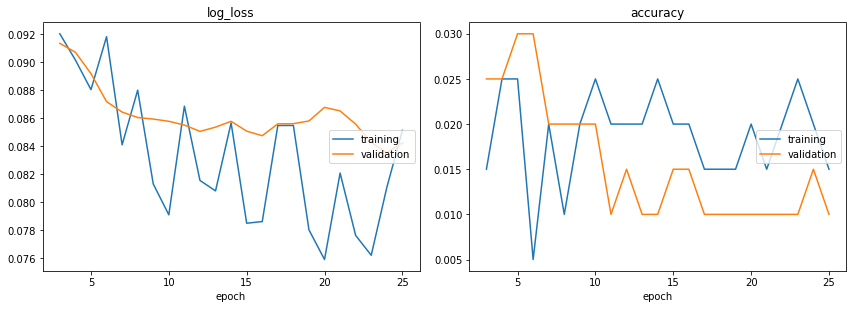

log_loss:
training   (min:    0.076, max:    0.092, cur:    0.085)
validation (min:    0.084, max:    0.092, cur:    0.084)

accuracy:
training   (min:    0.000, max:    0.025, cur:    0.015)
validation (min:    0.005, max:    0.030, cur:    0.010)


In [86]:
#Print training loss.

model, eval_data =  train_model(net, criterion, optimizer,n_epochs)


## 2.e. Evaluate model

In [87]:
#
#
# ------- Your Code -------
#
# 



dataiter = iter(testloader)
features, labels = dataiter.next()
outputs = net(features)
_ ,outputs = torch.max(outputs, 1)
_, labels_nonhot =  torch.max(labels,1)
accuracy = 100 * torch.sum(outputs == labels_nonhot) / len(outputs)
print('Overall test accuracy(%) : ', accuracy.item())



Overall test accuracy(%) :  28


/Users/mak/python3-venv/mlcysec/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


## 2.f. Save Model + Data

In [88]:
# Feel free to edit anything in this block

expt_name = 'model:mlp_tokenizer:foo_key3:val3_key4:val4'

model_out_path = '{}.checkpoint.pth'.format(expt_name)
save_model(model, model_out_path)

eval_out_path = '{}.eval.pickle'.format(expt_name)
print(eval_out_path)
save_data(eval_data, eval_out_path)

model:mlp_tokenizer:foo_key3:val3_key4:val4.eval.pickle


---

# 3. Analysis

## 3.a. Summary: Main Results

If you tried other approaches, summarize their results here.

|        | Input Representation | Model | Optimizer | Validation Metric | Test Metric |
|--------|----------------------|-------|-----------|-------------------|-------------|
| Model1 | Unigram tokens       | MLP   | SGD       | 12.34 %           | 23.45%      |
| Model2 (this notebook) |                      |       |           |                   |             |
| ...    |                      |       |           |                   |             |

## 3.b. Discussion

Enter your final summary here.

For instance, you can address:
- What was the performance you obtained with the simplest approach?
- Which vectorized input representations helped more than the others?
- Which malwares are difficult to detect and why?
- Which approach do you recommend to perform malware classification?